Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
####  Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training'
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation'
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

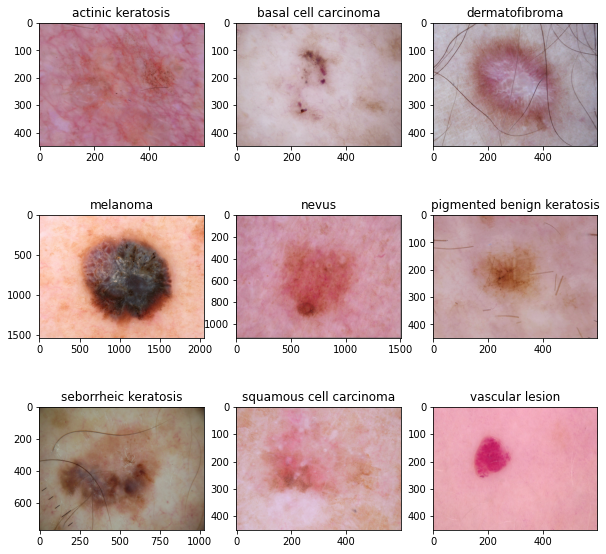

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# M1 model

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
num_class = 9
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 570s 2s/step - loss: 2.2543 - accuracy: 0.2679 - val_loss: 1.8188 - val_accuracy: 0.2998
Epoch 2/30
56/56 [==============================] - 3s 56ms/step - loss: 1.7132 - accuracy: 0.3761 - val_loss: 1.7178 - val_accuracy: 0.3758
Epoch 3/30
56/56 [==============================] - 3s 55ms/step - loss: 1.4771 - accuracy: 0.4838 - val_loss: 1.5186 - val_accuracy: 0.4698
Epoch 4/30
56/56 [==============================] - 3s 55ms/step - loss: 1.3746 - accuracy: 0.5212 - val_loss: 1.4278 - val_accuracy: 0.5168
Epoch 5/30
56/56 [==============================] - 3s 55ms/step - loss: 1.2857 - accuracy: 0.5491 - val_loss: 1.3750 - val_accuracy: 0.5481
Epoch 6/30
56/56 [==============================] - 3s 55ms/step - loss: 1.1760 - accuracy: 0.5865 - val_loss: 1.4298 - val_accuracy: 0.4966
Epoch 7/30
56/56 [==============================] - 3s 55ms/step - loss: 1.1035 - accuracy: 0.6183 - val_loss: 1.5861 - val_accuracy: 0.5101
Epoch 8/30
56

### Visualizing training results

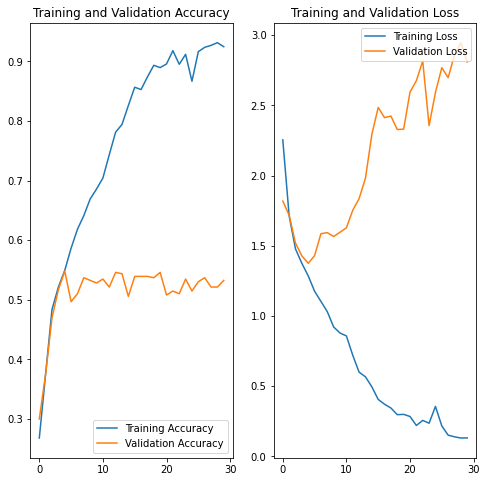

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

ANS: The model is overfitting because the accuracy on train dataset is quite high 0.927 while on the validation set is quite low i.e. 0.53.

There is also difference in loss functions in training & test.

# M2 model

In [17]:
#  after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

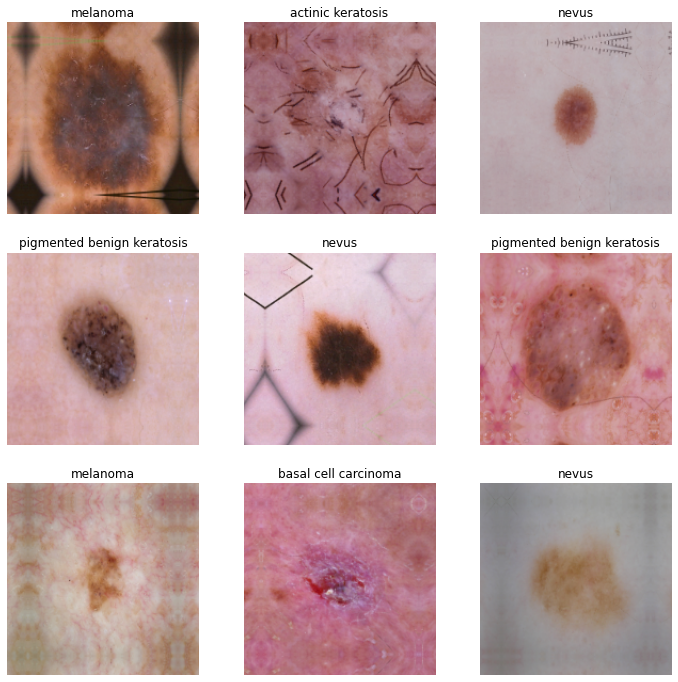

In [18]:
#  visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
## Your code goes here
num_class = 9
model = Sequential([
  data_augument,
  layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_class)
])

### Compiling the model

In [21]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 5s 60ms/step - loss: 2.1016 - accuracy: 0.2098 - val_loss: 1.9318 - val_accuracy: 0.2886
Epoch 2/30
56/56 [==============================] - 3s 55ms/step - loss: 1.8363 - accuracy: 0.3398 - val_loss: 1.7956 - val_accuracy: 0.3848
Epoch 3/30
56/56 [==============================] - 3s 55ms/step - loss: 1.5758 - accuracy: 0.4386 - val_loss: 1.4944 - val_accuracy: 0.4653
Epoch 4/30
56/56 [==============================] - 3s 55ms/step - loss: 1.4778 - accuracy: 0.4777 - val_loss: 1.4645 - val_accuracy: 0.4877
Epoch 5/30
56/56 [==============================] - 3s 55ms/step - loss: 1.4303 - accuracy: 0.4961 - val_loss: 1.4174 - val_accuracy: 0.5280
Epoch 6/30
56/56 [==============================] - 3s 56ms/step - loss: 1.3619 - accuracy: 0.5251 - val_loss: 1.3970 - val_accuracy: 0.4966
Epoch 7/30
56/56 [==============================] - 3s 56ms/step - loss: 1.3420 - accuracy: 0.5234 - val_loss: 1.3582 - val_accuracy: 0.5168
Epoch 8/30
56

### Visualizing the results

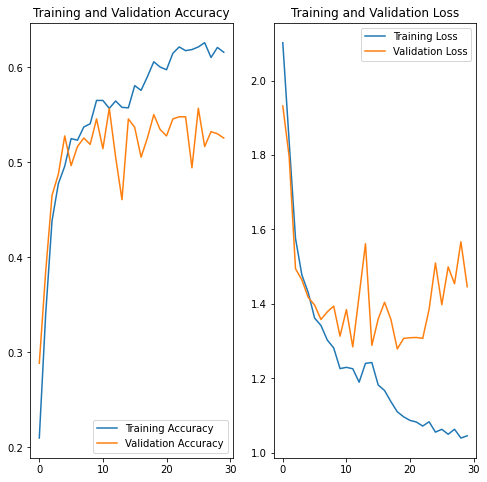

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation 

- We can increase the epochs to increase the accuracy 

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/app/Skin cancer ISIC ...,actinic keratosis
1,/content/gdrive/My Drive/app/Skin cancer ISIC ...,actinic keratosis
2,/content/gdrive/My Drive/app/Skin cancer ISIC ...,actinic keratosis
3,/content/gdrive/My Drive/app/Skin cancer ISIC ...,actinic keratosis
4,/content/gdrive/My Drive/app/Skin cancer ISIC ...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/app/Skin cancer ISIC ...,vascular lesion
2235,/content/gdrive/My Drive/app/Skin cancer ISIC ...,vascular lesion
2236,/content/gdrive/My Drive/app/Skin cancer ISIC ...,vascular lesion
2237,/content/gdrive/My Drive/app/Skin cancer ISIC ...,vascular lesion


In [26]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

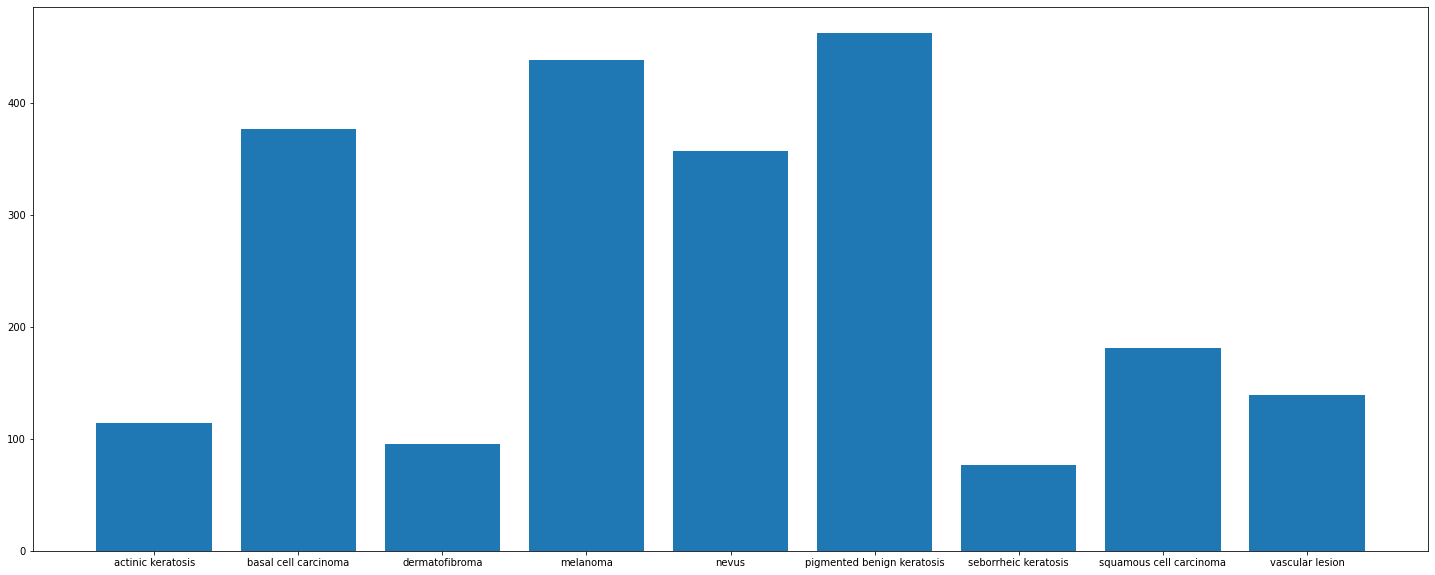

In [27]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Answer-1 :- **seborrheic keratosis** has least number of samples

Answer-2:- **actinic keratosis and dermatofibroma** have proportionate number of classes.
**melanoma and pigmented benign keratosis** have proprtionate number of classes

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset="/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i,save_format='jpg')
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA4C4721D0>: 100%|██████████| 500/500 [00:24<00:00, 20.01 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA4C9E9E50>: 100%|██████████| 500/500 [00:25<00:00, 19.39 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAA4C4AFE10>: 100%|██████████| 500/500 [00:24<00:00, 20.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FAA4C472C50>: 100%|██████████| 500/500 [02:01<00:00,  4.12 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FAA4C54EE50>: 100%|██████████| 500/500 [01:39<00:00,  5.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA4C4BA990>: 100%|██████████| 500/500 [00:21<00:00, 23.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAB5FA39190>: 100%|██████████| 500/500 [00:49<00:00, 10.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAA4C47BF50>: 100%|██████████| 500/500 [00:21<00:00, 23.57 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA4C50DC90>: 100%|██████████| 500/500 [00:21<00:00, 23.77 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [35]:
new_df['Label'].value_counts()


melanoma                      500
nevus                         500
seborrheic keratosis          500
actinic keratosis             500
dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
squamous cell carcinoma       500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# M3 Model

####  Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [37]:
data_dir_train=pathlib.Path("/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [39]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


#### Compile your model (Choose optimizer and loss function appropriately)

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


####  Train your model

In [41]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 225ms/step - loss: 2.4703 - accuracy: 0.3427 - val_loss: 2.1752 - val_accuracy: 0.1099
Epoch 2/30
169/169 [==============================] - 38s 216ms/step - loss: 1.3569 - accuracy: 0.4930 - val_loss: 1.9672 - val_accuracy: 0.2472
Epoch 3/30
169/169 [==============================] - 38s 216ms/step - loss: 1.1142 - accuracy: 0.5942 - val_loss: 1.6417 - val_accuracy: 0.3808
Epoch 4/30
169/169 [==============================] - 38s 216ms/step - loss: 0.9558 - accuracy: 0.6502 - val_loss: 1.0425 - val_accuracy: 0.5976
Epoch 5/30
169/169 [==============================] - 38s 218ms/step - loss: 0.7771 - accuracy: 0.7142 - val_loss: 1.2625 - val_accuracy: 0.5657
Epoch 6/30
169/169 [==============================] - 38s 218ms/step - loss: 0.6889 - accuracy: 0.7506 - val_loss: 4.2616 - val_accuracy: 0.2405
Epoch 7/30
169/169 [==============================] - 38s 216ms/step - loss: 0.5501 - accuracy: 0.7995 - val_loss: 1.0972 - val_ac

#### Visualize the model results

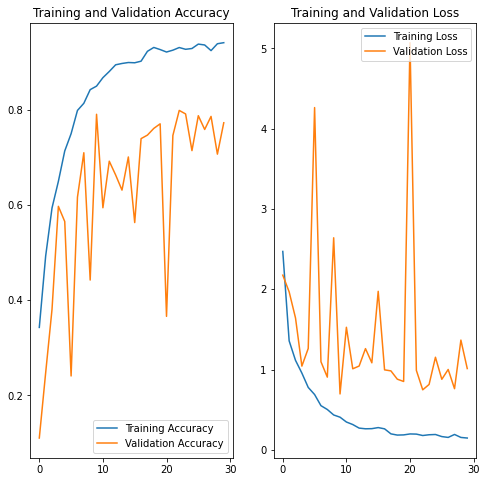

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Accuracy on training data has increased by using Augmentor library

Model is still overfitting

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

The Model can be further improved by tuning the hyperparameter